In [1]:
### adicionando import de libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
### setando uma seed
np.random.seed(2024)

In [3]:
### carregando o dataset de treino
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('train.csv', low_memory=False)

Saving train.csv to train.csv


In [4]:
### validando tipos
### a maioria dos dados estão em formato objeto, enquanto somente 8 em formato numérico (4 em float, 4 em int). Temos uma massa relevante de dados null, especialmente nas colunas Monthly_Inhand_Salary e Type_of_Loan. Podemos ver também algumas variáveis com tipos errados, como por exemplo, month, age...
### Estas serão tratadas posteriormente
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [5]:
### identificando colunas para entender melhor a "cara" do dataset
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [6]:
### verificando quantidade de nulos. Como verificado anteriormente, Monthly_Inhand_Salary e Type_of_Loan são as duas colunas com a maior quantidade de dados faltantes
df.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [8]:
### verificando variaveis quantitativas. As variáveis Monthly_Inhand_Salary e Total_EMI_per_month possuem valores em média muito maiores que as outras variáveis. Para um bom modelo, possivelmente precisaremos normalizar os dados de alguma maneira
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [13]:
### validando valores unicos por coluna do data set
### algumas coisas chamam anteção aqui:
### 1) A coluna Age possui idades com "_" e valores negativos
### 2) A coluna Occupation possui linhas com '_______' ao invés de serem vazias
### 3) A coluna Annual_Income possui valores com "_"
### 4) A coluna Monthly Inhand Salary possui valores nan
### 5) A coluna Num_of_Loan possui multiplos dados com "_"
### 6) A coluna Delay from due date possui valores negativos
### 7) A coluna Num of Delayed Payment possui nan e valores com "_"
### 8) A coluna Credit Mix possui valores com "_"
### 9) A coluna Outstanding Debt possui valores com "_"
### 10) Payment of min amount possui um valor = 'NM'
### 11) Payment behavior possui um valor estranho '!@9#%8'

### Em resumo, estes valores mencionados precisam ser tratados antes de partirmos para qualquer abordagem de dados

def print_unique(dataframe):
    for column in dataframe.columns:
        unique_values = dataframe[column].unique()
        print(f"Valores únicos na coluna '{column}':")
        print(unique_values)
        print("\n")


print_unique(df)

Valores únicos na coluna 'ID':
['0x1602' '0x1603' '0x1604' ... '0x25feb' '0x25fec' '0x25fed']


Valores únicos na coluna 'Customer_ID':
['CUS_0xd40' 'CUS_0x21b1' 'CUS_0x2dbc' ... 'CUS_0xaf61' 'CUS_0x8600'
 'CUS_0x942c']


Valores únicos na coluna 'Month':
['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


Valores únicos na coluna 'Name':
['Aaron Maashoh' nan 'Rick Rothackerj' ... 'Chris Wickhamm'
 'Sarah McBridec' 'Nicks']


Valores únicos na coluna 'Age':
['23' '-500' '28_' ... '4808_' '2263' '1342']


Valores únicos na coluna 'SSN':
['821-00-0265' '#F%$D@*&8' '004-07-5839' ... '133-16-7738' '031-35-0942'
 '078-73-5990']


Valores únicos na coluna 'Occupation':
['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']


Valores únicos na coluna 'Annual_Income':
['19114.12' '34847.84' '34847.84_' ... '20002.88' '39628.99' '39628.99_']


Val

In [10]:
### drop de colunas que não tem relevância para o treino (nem qualitativas nem quantitativas)
def drop_column_by_name(dataframe, columns):
    return dataframe.drop(columns=columns)

df_f = drop_column_by_name(df, ['ID', 'Month', 'Name', 'SSN'])

In [11]:
### info do novo dataframe
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Monthly_Inhand_Salary     84998 non-null   float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  object 
 9   Type_of_Loan              88592 non-null   object 
 10  Delay_from_due_date       100000 non-null  int64  
 11  Num_of_Delayed_Payment    92998 non-null   object 
 12  Changed_Credit_Limit      100000 non-null  object 
 13  Num_Credit_Inquiries      98035 non-null   fl

In [14]:
### tratamento de variaveis com tipos errados
wrong_columns_types = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
                   'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
                   'Monthly_Balance']

In [15]:
### além de precisar de uma mudança de tipo, a coluna Changed_Credit_Limit também precisa ser tratada para excluir os "_"
def replace_underscore_to_nan(dataframe, types):
    for t in types:
        dataframe.loc[dataframe[t] == '_', t] = np.nan

replace_underscore_to_nan(df_f, ['Changed_Credit_Limit'])

df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Age                       100000 non-null  object 
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  object 
 4   Monthly_Inhand_Salary     84998 non-null   float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  object 
 9   Type_of_Loan              88592 non-null   object 
 10  Delay_from_due_date       100000 non-null  int64  
 11  Num_of_Delayed_Payment    92998 non-null   object 
 12  Changed_Credit_Limit      97909 non-null   object 
 13  Num_Credit_Inquiries      98035 non-null   fl

In [16]:
### remoção dos "_" mencionados anteriormente
def change_wrong_types_to_float(dataframe, types):
    for t in types:
        dataframe[t] = dataframe[t].str.replace('_','').astype('float64')

change_wrong_types_to_float(df_f, wrong_columns_types)


In [17]:
### checando dataframe. Agora os tipos parecem estar todos corretos
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Age                       100000 non-null  float64
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  float64
 4   Monthly_Inhand_Salary     84998 non-null   float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  float64
 9   Type_of_Loan              88592 non-null   object 
 10  Delay_from_due_date       100000 non-null  int64  
 11  Num_of_Delayed_Payment    92998 non-null   float64
 12  Changed_Credit_Limit      97909 non-null   float64
 13  Num_Credit_Inquiries      98035 non-null   fl

In [18]:
### verificando nulos
df_f.isna().sum()

Customer_ID                     0
Age                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit         2091
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

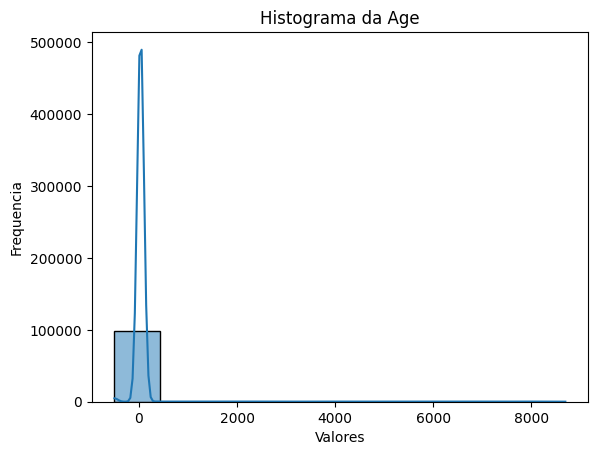

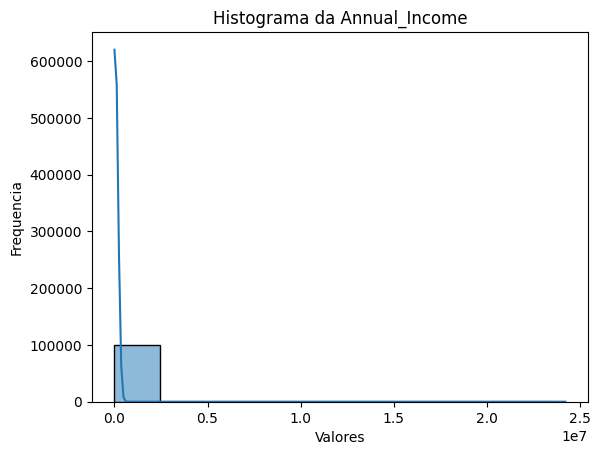

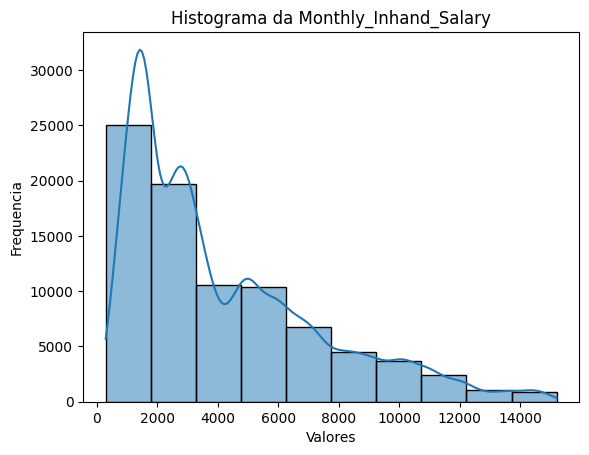

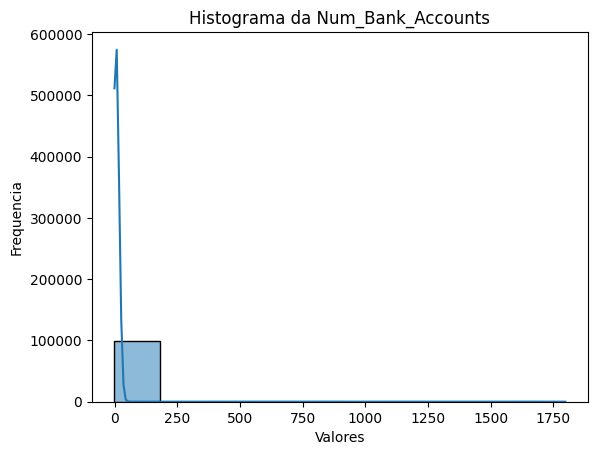

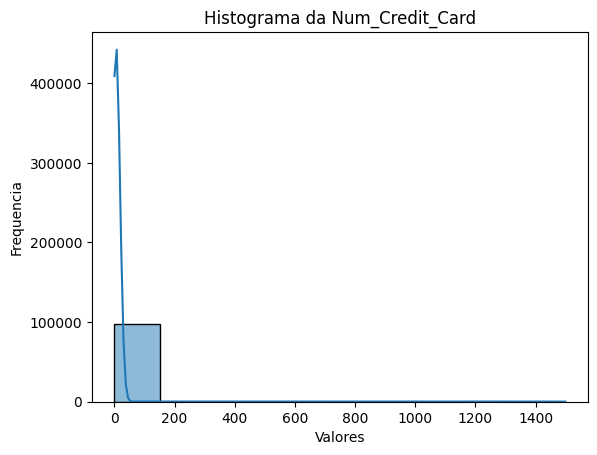

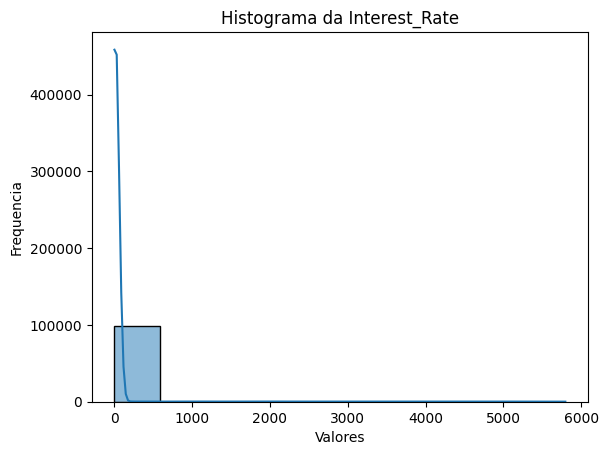

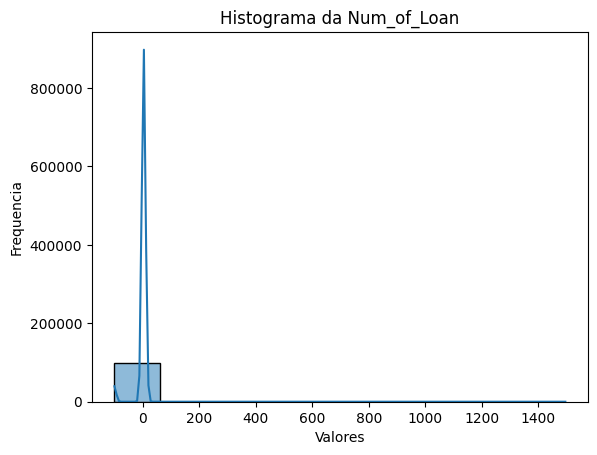

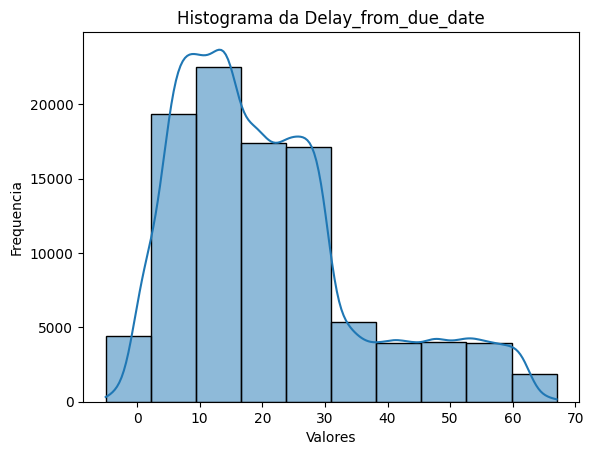

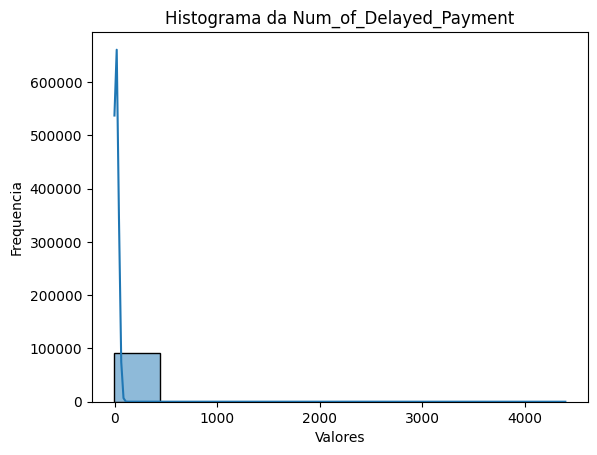

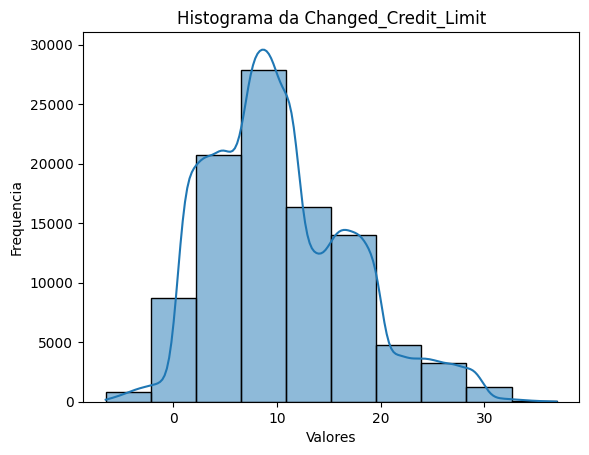

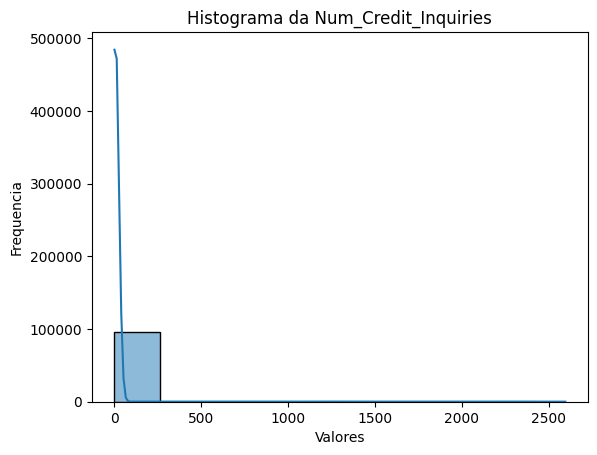

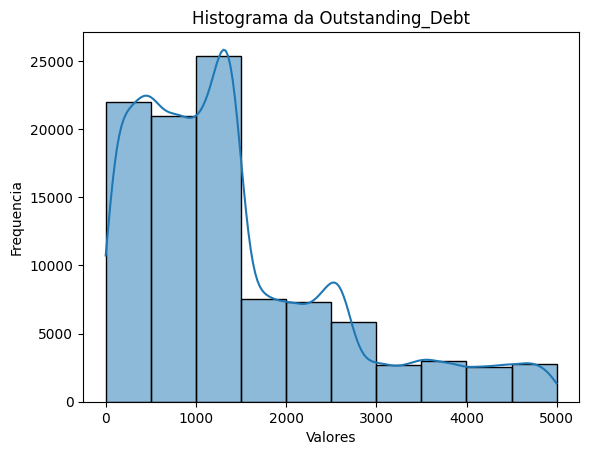

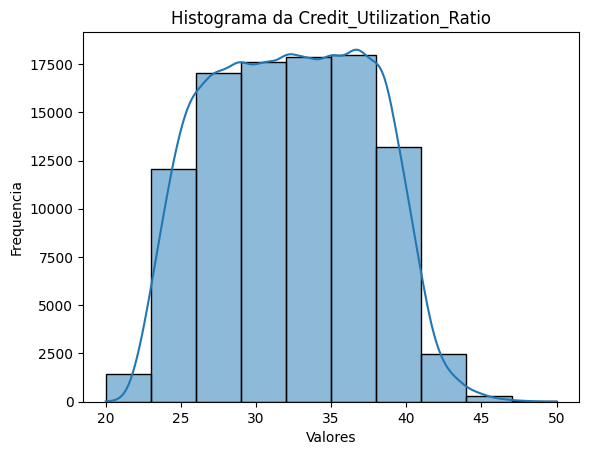

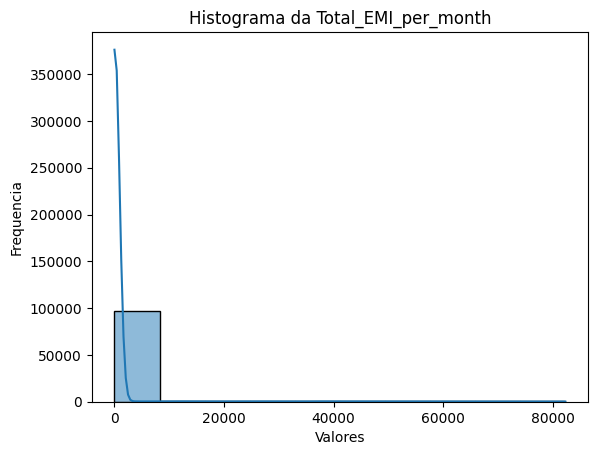

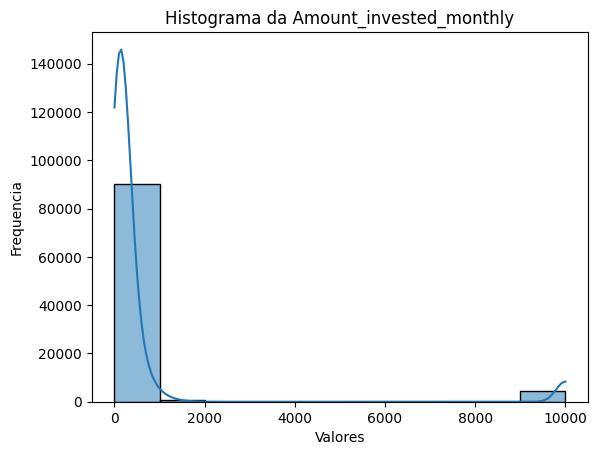

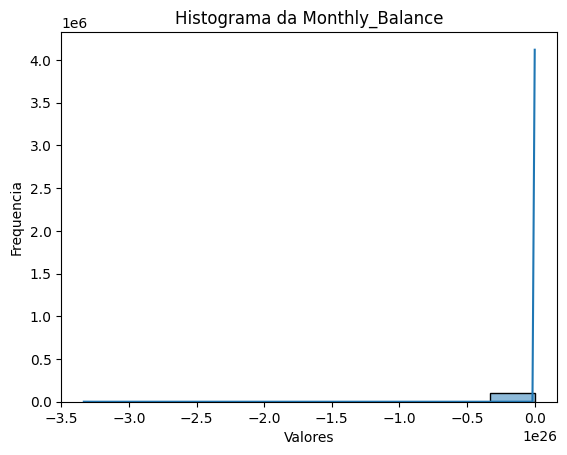

In [19]:
### verificando distribuição dos dados numericos. A distribuição não está ideal para a maioria dos dados. Vamos tratar todos
for c in df_f.columns:
    if df_f[c].dtype in ['int64', 'float64']:
        sns.histplot(df_f[c], bins=10, kde=True)
        plt.title(f'Histograma da {c}')
        plt.xlabel('Valores')
        plt.ylabel('Frequencia')
        plt.show()

In [ ]:
### identificamos que age possui valores anormais,
### para preencher os valores iremos analisar se a variavel possui correlação com outras variaveis

In [20]:
### iniciando pelo age
df_f['Age'].describe()

count    100000.000000
mean        110.649700
std         686.244717
min        -500.000000
25%          24.000000
50%          33.000000
75%          42.000000
max        8698.000000
Name: Age, dtype: float64

In [21]:
### contando valores unicos
df_f['Age'].value_counts()

Age
38.0      2994
28.0      2968
31.0      2955
26.0      2945
32.0      2884
          ... 
1908.0       1
4583.0       1
7549.0       1
3119.0       1
1342.0       1
Name: count, Length: 1728, dtype: int64

In [108]:
#A grande maioria dos dados faltantes ou que estão de certa maneira disruptindo as distribuições são dados do mesmo cliente.
#Ao investigar o banco de dados em uma planilha fica mais claro: a base possui dados mensais de diversos clientes, de maneira ordenada. A maioria dos dados faltantes podem ser substituidos pela moda dos meses anteriores de dados do mesmo cliente (estes dados faltantes geralmente são dados constantes)
#A abordagem de solução será essa para a maioria dos casos onde isso se aplica

In [22]:
### com base nesse entendimento vamos transformar os outliers de age com base no customer id em valores mais próximos das idades reais
age_outlier = (df_f['Age'] < 0) | (df_f['Age'] > 60)

mode_of_age =  df_f.groupby('Customer_ID')['Age'].transform(lambda x : x.mode().iloc[0])

df_f['Age'] = np.where(age_outlier, mode_of_age, df_f['Age'])
df_f['Age'] = df_f['Age'].astype(int)

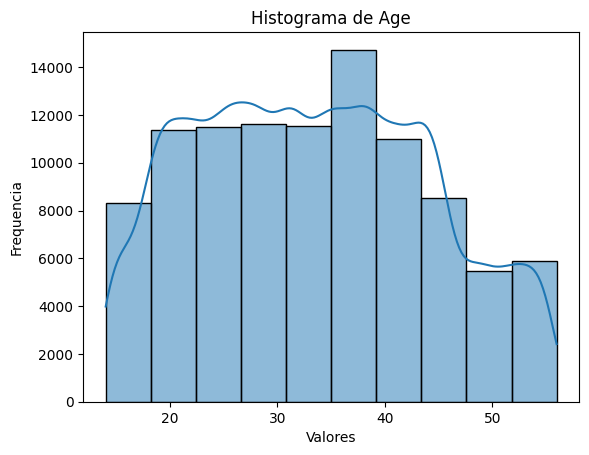

In [23]:
### plotando o gráfico novamente
sns.histplot(df_f['Age'], bins=10, kde=True)
plt.title('Histograma de Age')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [24]:
### iniciando pelo age
df_f['Age'].describe()

count    100000.000000
mean         33.311180
std          10.764783
min          14.000000
25%          24.000000
50%          33.000000
75%          42.000000
max          56.000000
Name: Age, dtype: float64

In [25]:
### vamos fazer a mesma coisa para varivel ocupação que possui valores preenchidos incosistentes
def qtd_por_grupo(dataframe, coluna1, coluna2):
    grupos = dataframe.groupby(coluna1)

    i = 0
    for valor, grupo in grupos:

        if i < 10:
            qtd = len(grupo[coluna2])

            print(f"Valor de {coluna1}: {valor}")
            print(f"Valores de {coluna2}: {grupo[coluna2].tolist()}")
            print(f"Qtd de {coluna2}: {qtd}")
            print()

            i+=1


qtd_por_grupo(df_f,'Customer_ID','Occupation')

Valor de Customer_ID: CUS_0x1000
Valores de Occupation: ['Lawyer', 'Lawyer', 'Lawyer', 'Lawyer', 'Lawyer', 'Lawyer', 'Lawyer', 'Lawyer']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x1009
Valores de Occupation: ['Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', '_______', 'Mechanic', 'Mechanic']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x100b
Valores de Occupation: ['Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x1011
Valores de Occupation: ['Doctor', 'Doctor', 'Doctor', 'Doctor', 'Doctor', 'Doctor', 'Doctor', 'Doctor']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x1013
Valores de Occupation: ['Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x1015
Valores de Occupation: ['Journalist', 'Journalist', 'Journalist', 'Journalist', 'Jour

In [26]:
### com base na regra existe uma correlação direta onde podemos utlizar um método parecido com o da Idade
mode_of_occupation =  df_f.groupby('Customer_ID')['Occupation'].transform(lambda x : x.mode().iloc[0])

df_f['Occupation'] = mode_of_occupation

qtd_por_grupo(df_f,'Customer_ID','Occupation')

Valor de Customer_ID: CUS_0x1000
Valores de Occupation: ['Lawyer', 'Lawyer', 'Lawyer', 'Lawyer', 'Lawyer', 'Lawyer', 'Lawyer', 'Lawyer']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x1009
Valores de Occupation: ['Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x100b
Valores de Occupation: ['Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager', 'Media_Manager']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x1011
Valores de Occupation: ['Doctor', 'Doctor', 'Doctor', 'Doctor', 'Doctor', 'Doctor', 'Doctor', 'Doctor']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x1013
Valores de Occupation: ['Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic', 'Mechanic']
Qtd de Occupation: 8

Valor de Customer_ID: CUS_0x1015
Valores de Occupation: ['Journalist', 'Journalist', 'Journalist', 'Journalist', 'Jou

In [27]:
### contando valores. Ainda assim sobraram 8 valores "_______"
df_f['Occupation'].value_counts()

Occupation
Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6712
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
_______             8
Name: count, dtype: int64

In [28]:
### vamos executar a mesma lógica para o atributo de salario mensal
qtd_por_grupo(df_f,'Customer_ID','Monthly_Inhand_Salary')

Valor de Customer_ID: CUS_0x1000
Valores de Monthly_Inhand_Salary: [2706.1616666666664, nan, 2706.1616666666664, 2706.1616666666664, 2706.1616666666664, 2706.1616666666664, 2706.1616666666664, 2706.1616666666664]
Qtd de Monthly_Inhand_Salary: 8

Valor de Customer_ID: CUS_0x1009
Valores de Monthly_Inhand_Salary: [4250.39, 4250.39, 4250.39, 4250.39, 4250.39, 4250.39, 4250.39, 4250.39]
Qtd de Monthly_Inhand_Salary: 8

Valor de Customer_ID: CUS_0x100b
Valores de Monthly_Inhand_Salary: [9549.7825, 9549.7825, nan, 9549.7825, 9549.7825, 9549.7825, 9549.7825, 9549.7825]
Qtd de Monthly_Inhand_Salary: 8

Valor de Customer_ID: CUS_0x1011
Valores de Monthly_Inhand_Salary: [5208.8725, 5208.8725, 5208.8725, 5208.8725, 5208.8725, 5208.8725, nan, 5208.8725]
Qtd de Monthly_Inhand_Salary: 8

Valor de Customer_ID: CUS_0x1013
Valores de Monthly_Inhand_Salary: [nan, nan, 7962.415000000001, 7962.415000000001, 7962.415000000001, 7962.415000000001, 7962.415000000001, nan]
Qtd de Monthly_Inhand_Salary: 8

Valo

In [29]:
mode_of_monthly_salary =  df_f.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(lambda x : x.mode().iloc[0])

df_f['Monthly_Inhand_Salary'] = np.where(df['Monthly_Inhand_Salary'].isna(), mode_of_monthly_salary, df['Monthly_Inhand_Salary'])

qtd_por_grupo(df_f,'Customer_ID','Monthly_Inhand_Salary')

Valor de Customer_ID: CUS_0x1000
Valores de Monthly_Inhand_Salary: [2706.1616666666664, 2706.1616666666664, 2706.1616666666664, 2706.1616666666664, 2706.1616666666664, 2706.1616666666664, 2706.1616666666664, 2706.1616666666664]
Qtd de Monthly_Inhand_Salary: 8

Valor de Customer_ID: CUS_0x1009
Valores de Monthly_Inhand_Salary: [4250.39, 4250.39, 4250.39, 4250.39, 4250.39, 4250.39, 4250.39, 4250.39]
Qtd de Monthly_Inhand_Salary: 8

Valor de Customer_ID: CUS_0x100b
Valores de Monthly_Inhand_Salary: [9549.7825, 9549.7825, 9549.7825, 9549.7825, 9549.7825, 9549.7825, 9549.7825, 9549.7825]
Qtd de Monthly_Inhand_Salary: 8

Valor de Customer_ID: CUS_0x1011
Valores de Monthly_Inhand_Salary: [5208.8725, 5208.8725, 5208.8725, 5208.8725, 5208.8725, 5208.8725, 5208.8725, 5208.8725]
Qtd de Monthly_Inhand_Salary: 8

Valor de Customer_ID: CUS_0x1013
Valores de Monthly_Inhand_Salary: [7962.415000000001, 7962.415000000001, 7962.415000000001, 7962.415000000001, 7962.415000000001, 7962.415000000001, 7962.4

In [ ]:
### vamos fazer o mesmo para todas as variaveis que apresentaram valores negativos r outliers

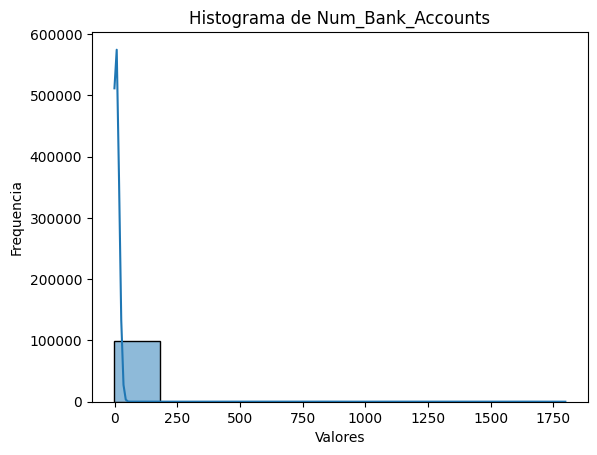

In [30]:
### tratando num bank account
sns.histplot(df_f['Num_Bank_Accounts'], bins=10, kde=True)
plt.title('Histograma de Num_Bank_Accounts')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

Intervalo interquartil (IQR): 4.0


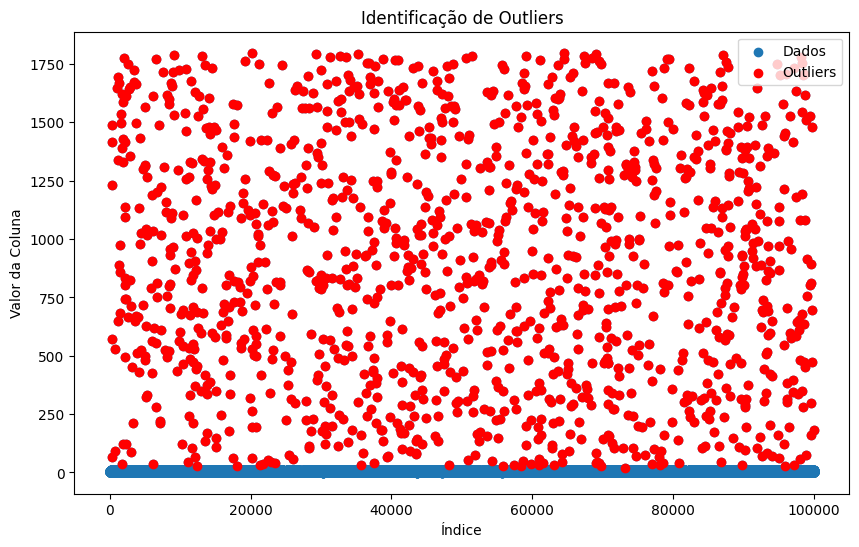

In [31]:
Q1 = np.percentile(df_f['Num_Bank_Accounts'], 25)
Q3 = np.percentile(df_f['Num_Bank_Accounts'], 75)

IQR = Q3 - Q1

print("Intervalo interquartil (IQR):", IQR)

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_f[(df_f['Num_Bank_Accounts'] < limite_inferior) | (df_f['Num_Bank_Accounts'] > limite_superior)]

plt.figure(figsize=(10, 6))
plt.scatter(df_f.index, df_f['Num_Bank_Accounts'], label='Dados')
plt.scatter(outliers.index, outliers['Num_Bank_Accounts'], color='r', label='Outliers')
plt.xlabel('Índice')
plt.ylabel('Valor da Coluna')
plt.title('Identificação de Outliers')
plt.legend()
plt.show()

In [32]:
### tratando os dados
account_invalids = (df_f['Num_Bank_Accounts'] < 0)
df_f['Num_Bank_Accounts'] =  np.where(account_invalids, 0, df_f['Num_Bank_Accounts'])

account_outliers = (df_f['Num_Bank_Accounts'] > 11)

mode_accounts = df_f.groupby('Customer_ID')['Num_Bank_Accounts'].transform(lambda x : x.mode().iloc[0])
df_f['Num_Bank_Accounts'] = np.where(account_outliers, mode_accounts, df_f['Num_Bank_Accounts'])

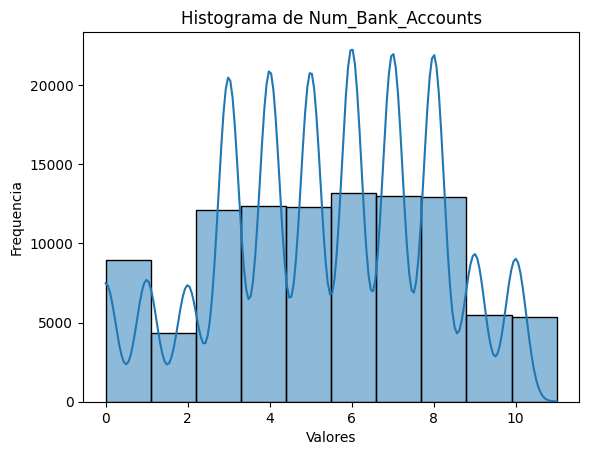

In [33]:
### Checando novamente a distribuição de num bank accounts. Agora o dado parece estar melhor
sns.histplot(df_f['Num_Bank_Accounts'], bins=10, kde=True)
plt.title('Histograma de Num_Bank_Accounts')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

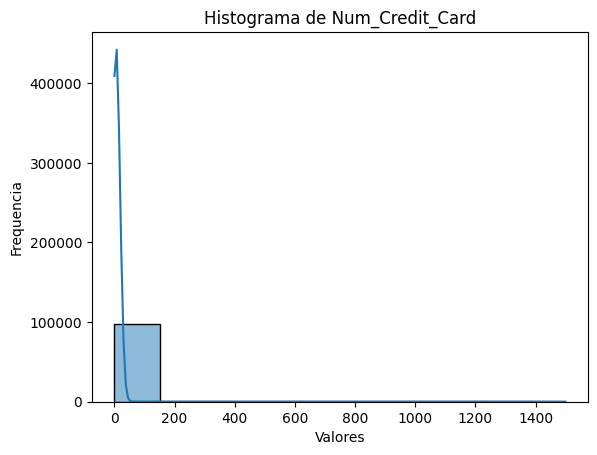

In [34]:
### tratando num credit cards
sns.histplot(df_f['Num_Credit_Card'], bins=10, kde=True)
plt.title('Histograma de Num_Credit_Card')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [35]:
### tratando os dados
credit_card_invalids = (df_f['Num_Credit_Card'] < 0)
df_f['Num_Credit_Card'] =  np.where(credit_card_invalids, 0, df_f['Num_Credit_Card'])

credit_card_outliers = (df_f['Num_Credit_Card'] > 15)

mode_credit_card = df_f.groupby('Customer_ID')['Num_Credit_Card'].transform(lambda x : x.mode().iloc[0])
df_f['Num_Credit_Card'] = np.where(credit_card_outliers, mode_credit_card, df_f['Num_Credit_Card'])

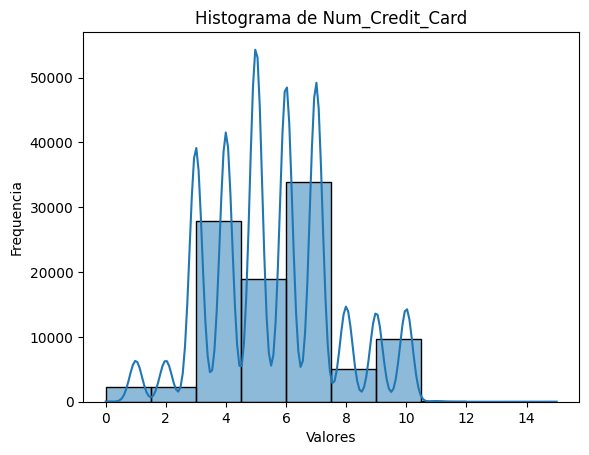

In [36]:
### Após tratamento, dado Num_Credit_Card parece melhor distribuído
sns.histplot(df_f['Num_Credit_Card'], bins=10, kde=True)
plt.title('Histograma de Num_Credit_Card')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

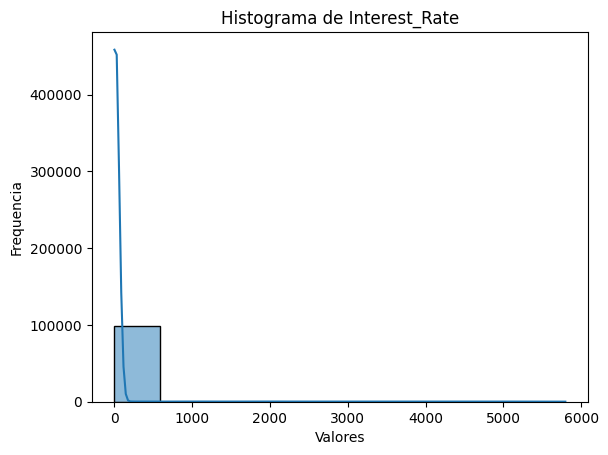

In [37]:
### tratando interest rate com a mesma lógica
sns.histplot(df_f['Interest_Rate'], bins=10, kde=True)
plt.title('Histograma de Interest_Rate')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [38]:
### tratando os dados
interest_rate_outliers = (df_f['Interest_Rate'] > 50)

mode_interest_rate = df_f.groupby('Customer_ID')['Interest_Rate'].transform(lambda x : x.mode().iloc[0])
df_f['Interest_Rate'] = np.where(interest_rate_outliers, mode_interest_rate, df_f['Interest_Rate'])

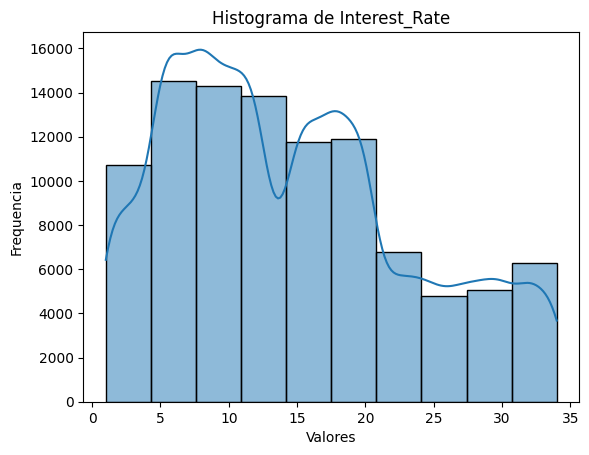

In [39]:
### interest rate agora mais bem distribuído
sns.histplot(df_f['Interest_Rate'], bins=10, kde=True)
plt.title('Histograma de Interest_Rate')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

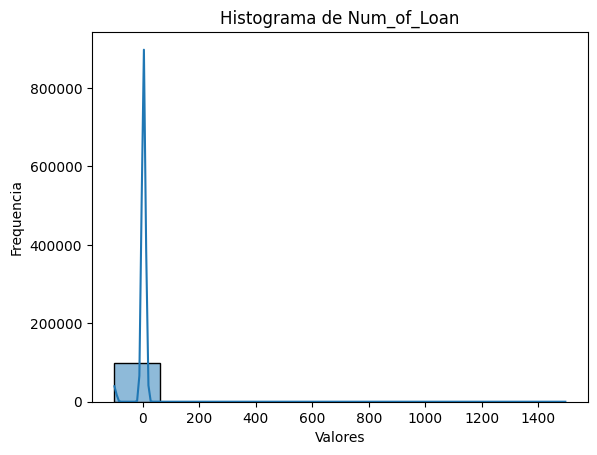

In [40]:
### tratando num of loan
sns.histplot(df_f['Num_of_Loan'], bins=10, kde=True)
plt.title('Histograma de Num_of_Loan')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [41]:
### tratando num of loan
outlier_loan = (df_f['Num_of_Loan'] > 10) | (df_f['Num_of_Loan'] < 0 )

mode_Loan = df_f.groupby('Customer_ID')['Num_of_Loan'].transform(lambda x : x.mode().iloc[0])
df_f['Num_of_Loan'] = np.where(outlier_loan, mode_Loan, df_f['Num_of_Loan'])

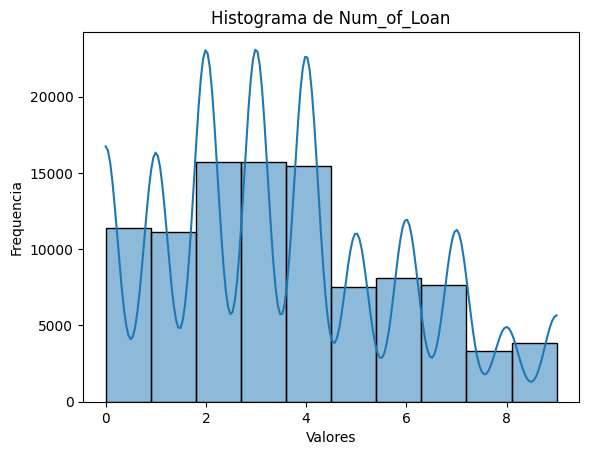

In [42]:
### num of loan agora mais bem distribuido
sns.histplot(df_f['Num_of_Loan'], bins=10, kde=True)
plt.title('Histograma de Num_of_Loan')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

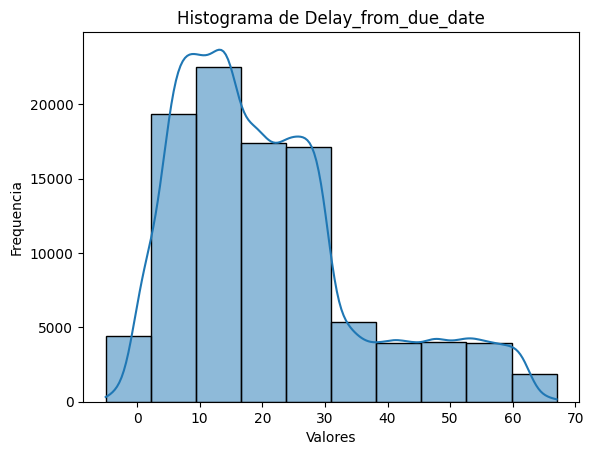

In [43]:
### tratando delay from dua date. Este possui valores negativos, inclusive
sns.histplot(df_f['Delay_from_due_date'], bins=10, kde=True)
plt.title('Histograma de Delay_from_due_date')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [44]:
### tratando delay from due date
outlier_delay = (df_f['Delay_from_due_date'] < 0 )

mode_delay = df_f.groupby('Customer_ID')['Delay_from_due_date'].transform(lambda x : x.mode().iloc[0])
df_f['Delay_from_due_date'] = np.where(outlier_delay, mode_Loan, df_f['Delay_from_due_date'])

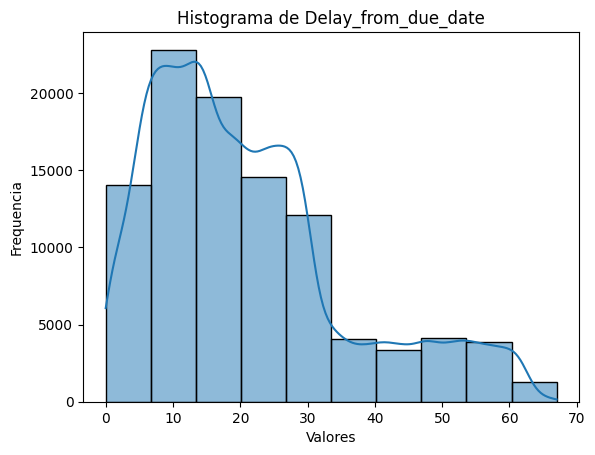

In [45]:
### Pós tratamento a curva não muda tanto, porém agora o dado está livre de numeros negativos
sns.histplot(df_f['Delay_from_due_date'], bins=10, kde=True)
plt.title('Histograma de Delay_from_due_date')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [46]:
### Ainda possuímos uma massa relevante de dados null
df_f.isnull().sum()

Customer_ID                     0
Age                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary           0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit         2091
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

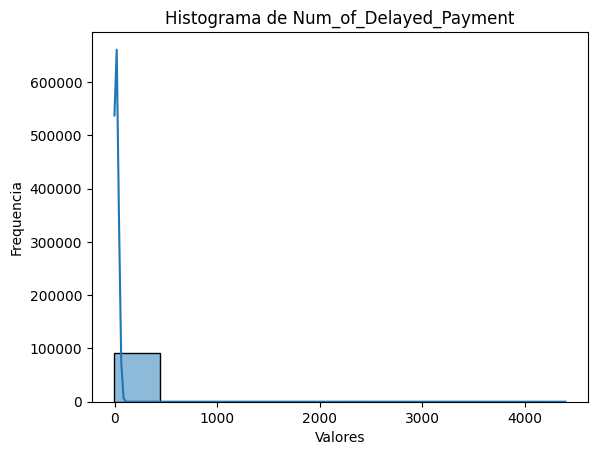

In [47]:
### tratando Num_of_Delayed_Payment
sns.histplot(df_f['Num_of_Delayed_Payment'], bins=10, kde=True)
plt.title('Histograma de Num_of_Delayed_Payment')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [48]:
### preenchendo valores faltantes
outlier_delay_payment = (df_f['Num_of_Delayed_Payment'] > 30) | (df_f['Num_of_Delayed_Payment'] < 0)

mode_Delay_Payment = df_f.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda x : x.mode().iloc[0])
df_f['Num_of_Delayed_Payment'] = np.where(outlier_delay_payment, mode_Delay_Payment, df_f['Num_of_Delayed_Payment'])

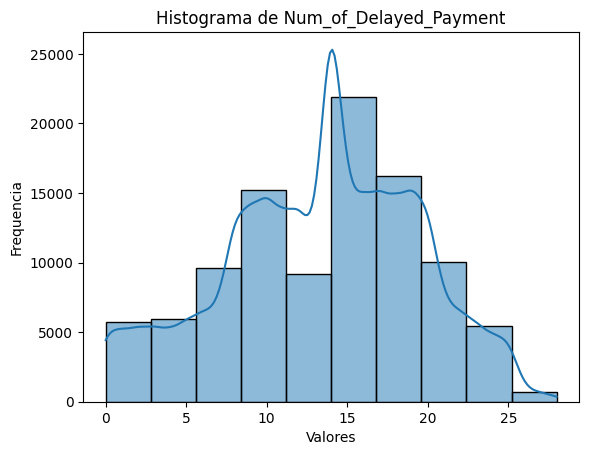

In [55]:
### Num_of_Delayed_Payment agora tratado, com uma distribuição muito melhor, porém ainda temos uma massa relevante de linhas sem dado, conforme apontado no bloco executado anteriomente
sns.histplot(df_f['Num_of_Delayed_Payment'], bins=10, kde=True)
plt.title('Histograma de Num_of_Delayed_Payment')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [50]:
### tratando valores negativos
df_f['Num_of_Delayed_Payment'] = df_f['Num_of_Delayed_Payment'].apply(lambda x: np.nan if x < 0 else x)


### preenchendo valores nulos com a média dos outros
df_f['Num_of_Delayed_Payment'] = df_f['Num_of_Delayed_Payment'].fillna(df_f['Num_of_Delayed_Payment'].median())

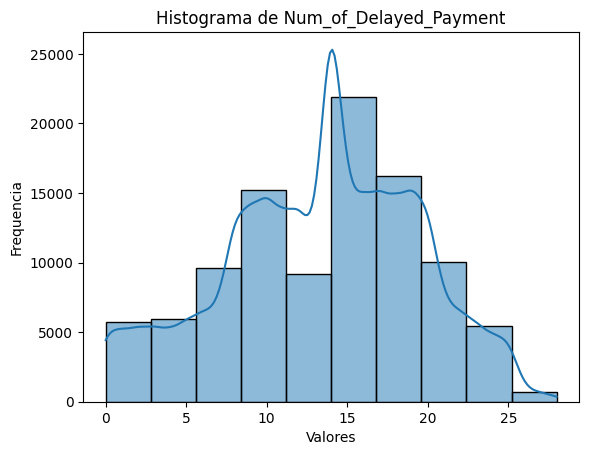

In [51]:
### Num_of_Delayed_Payment pós tratamento final
sns.histplot(df_f['Num_of_Delayed_Payment'], bins=10, kde=True)
plt.title('Histograma de Num_of_Delayed_Payment')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

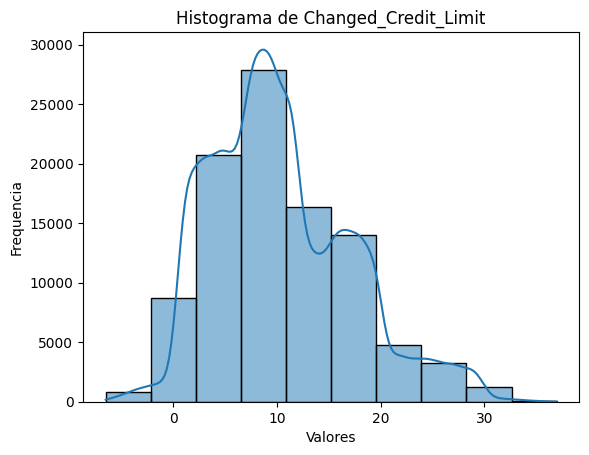

In [56]:
### tratando Changed_Credit_Limit
sns.histplot(df_f['Changed_Credit_Limit'], bins=10, kde=True)
plt.title('Histograma de Changed_Credit_Limit')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [57]:
### tratando Changed_Credit_Limit
outlier_credit = df_f['Changed_Credit_Limit'].isna()

mode_Credit = df_f.groupby('Customer_ID')['Changed_Credit_Limit'].transform(lambda x : x.mode().iloc[0])
df_f['Changed_Credit_Limit'] = np.where(outlier_credit, mode_Credit, df_f['Changed_Credit_Limit'])

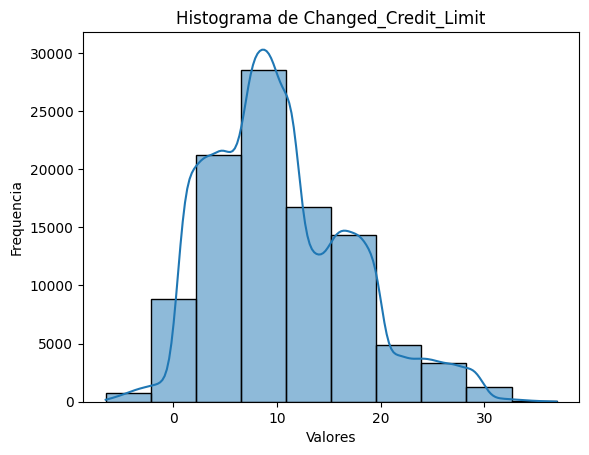

In [58]:
### Changed_Credit_Limit pós tratamento final
sns.histplot(df_f['Changed_Credit_Limit'], bins=10, kde=True)
plt.title('Histograma de Changed_Credit_Limit')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

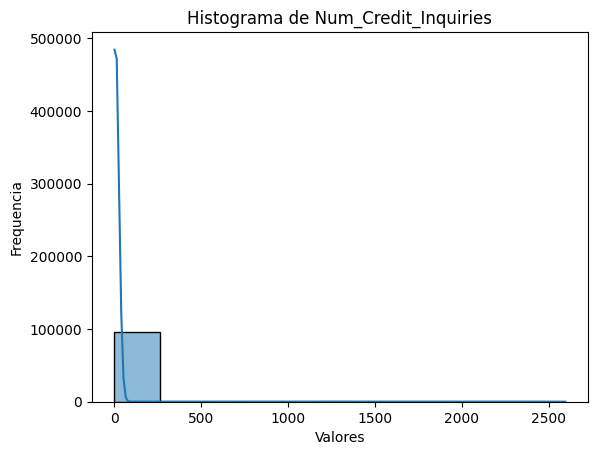

In [59]:
### tratando Num_Credit_Inquiries
sns.histplot(df_f['Num_Credit_Inquiries'], bins=10, kde=True)
plt.title('Histograma de Num_Credit_Inquiries')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [60]:
### tratando Num_Credit_Inquiries
df_f['Num_Credit_Inquiries'] = df_f['Num_Credit_Inquiries'].fillna(-1)
df_f['Num_Credit_Inquiries'] = df_f['Num_Credit_Inquiries'].astype(float).astype(int)

outlier_inquiries = (df_f['Num_Credit_Inquiries'] > 30) | (df_f['Num_Credit_Inquiries'] == -1)

mode_Inquiries = df_f.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(lambda x : x.mode().iloc[0])
df_f['Num_Credit_Inquiries'] = np.where(outlier_inquiries, mode_Inquiries, df_f['Num_Credit_Inquiries'])

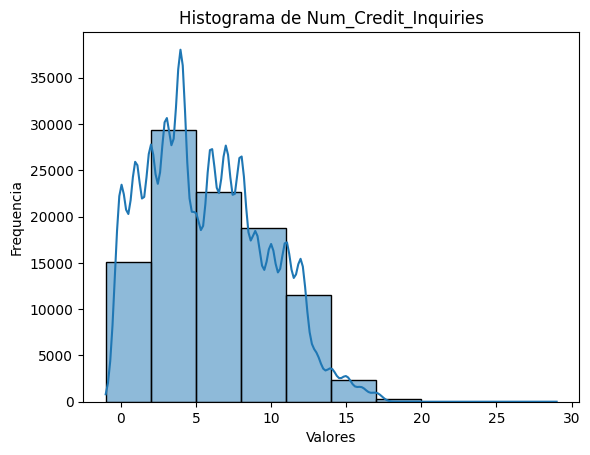

In [61]:
### Num_Credit_Inquiries agora tratado e mais bem distribuido, porém ainda temos valores negativos
sns.histplot(df_f['Num_Credit_Inquiries'], bins=10, kde=True)
plt.title('Histograma de Num_Credit_Inquiries')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [62]:
### tratando valores negativos
df_f['Num_Credit_Inquiries'] = df_f['Num_Credit_Inquiries'].apply(lambda x: np.nan if x < 0 else x)


### preenchendo valores nulos com a média dos outros
df_f['Num_Credit_Inquiries'] = df_f['Num_Credit_Inquiries'].fillna(df_f['Num_Credit_Inquiries'].median())

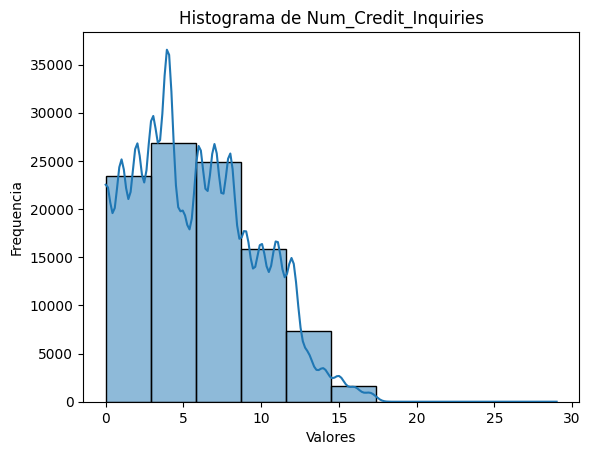

In [63]:
### Num_Credit_Inquiries agora com tratamento final
sns.histplot(df_f['Num_Credit_Inquiries'], bins=10, kde=True)
plt.title('Histograma de Num_Credit_Inquiries')
plt.xlabel('Valores')
plt.ylabel('Frequencia')
plt.show()

In [64]:
### tratamento Credit_Mix
qtd_por_grupo(df_f,'Customer_ID','Credit_Mix')

Valor de Customer_ID: CUS_0x1000
Valores de Credit_Mix: ['Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1009
Valores de Credit_Mix: ['Standard', 'Standard', 'Standard', '_', '_', 'Standard', 'Standard', '_']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x100b
Valores de Credit_Mix: ['Good', '_', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1011
Valores de Credit_Mix: ['Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1013
Valores de Credit_Mix: ['Good', 'Good', 'Good', 'Good', '_', 'Good', 'Good', 'Good']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1015
Valores de Credit_Mix: ['Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1018
Valores de Credit_Mix: ['Bad', '_', 'Bad', '_', 

In [65]:
### tratamento Credit_Mix

notfilled_credit_mix = df_f['Credit_Mix'] == '_'

mode_Credit_Mix = df_f.groupby('Customer_ID')['Credit_Mix'].transform(lambda x : x.mode().iloc[0])
df_f['Credit_Mix'] = np.where(notfilled_credit_mix, mode_Credit_Mix, df['Credit_Mix'])

In [66]:
### Credit_Mix agora com tratamento final
qtd_por_grupo(df_f,'Customer_ID','Credit_Mix')

Valor de Customer_ID: CUS_0x1000
Valores de Credit_Mix: ['Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad', 'Bad']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1009
Valores de Credit_Mix: ['Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x100b
Valores de Credit_Mix: ['Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1011
Valores de Credit_Mix: ['Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1013
Valores de Credit_Mix: ['Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1015
Valores de Credit_Mix: ['Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard', 'Standard']
Qtd de Credit_Mix: 8

Valor de Customer_ID: CUS_0x1018
Valores de Credit_Mix

In [67]:
### tratamento Payment_of_Min_Amount
df_f['Payment_of_Min_Amount'].unique()

array(['No', 'NM', 'Yes'], dtype=object)

In [68]:
### tratamento Payment_of_Min_Amount
df_f['Payment_of_Min_Amount'] = df_f['Payment_of_Min_Amount'].replace('NM', 'No')

In [69]:
### tratamento Payment_of_Min_Amount. Aqui tudo parece OK
df_f['Payment_of_Min_Amount'].unique()

array(['No', 'Yes'], dtype=object)

In [70]:
### tratando Amount_invested_monthly
df_f['Amount_invested_monthly'] = df_f['Amount_invested_monthly'].replace(10000.000000, np.nan)

### preenchendo valores nulos com a média dos outros
df_f['Amount_invested_monthly'] = df_f['Amount_invested_monthly'].fillna(df_f['Amount_invested_monthly'].median())

In [71]:
### tratando Monthly_Balance
### preenchendo valores nulos com a média dos outros
df_f['Monthly_Balance'] = df_f['Monthly_Balance'].fillna(df_f['Monthly_Balance'].median())

In [72]:
### tratando Credit_History_Age transformando em dias

df_f['Credit_History_Age'] = df_f['Credit_History_Age'].fillna(0)

df_f['Credit_History_Age'] = df_f['Credit_History_Age'].astype(str)

df_f['History_Age'] = df_f['Credit_History_Age'].apply(lambda x: int(x.split()[0]) * 12 + int(x.split()[3]) if len(x.split()) == 5 else 0)

df_f['History_Age'].head()

0    265
1      0
2    267
3    268
4    269
Name: History_Age, dtype: int64

In [73]:
### tratando nulos
df_f['History_Age'] = df_f['History_Age'].replace(0,np.nan)
df_f['History_Age'] = df_f.groupby('Customer_ID')['History_Age'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x)

In [74]:
### Dropando agora que criamos History_age
df_f = df_f.drop(['Credit_History_Age'], axis = 1)

In [75]:
### A única coluna ainda com valores nulos é Type of Loan. Ainda vamos tratá-la
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Age                       100000 non-null  int64  
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  float64
 4   Monthly_Inhand_Salary     100000 non-null  float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  float64
 9   Type_of_Loan              88592 non-null   object 
 10  Delay_from_due_date       100000 non-null  float64
 11  Num_of_Delayed_Payment    100000 non-null  float64
 12  Changed_Credit_Limit      100000 non-null  float64
 13  Num_Credit_Inquiries      100000 non-null  fl

<Axes: xlabel='Credit_Score', ylabel='count'>

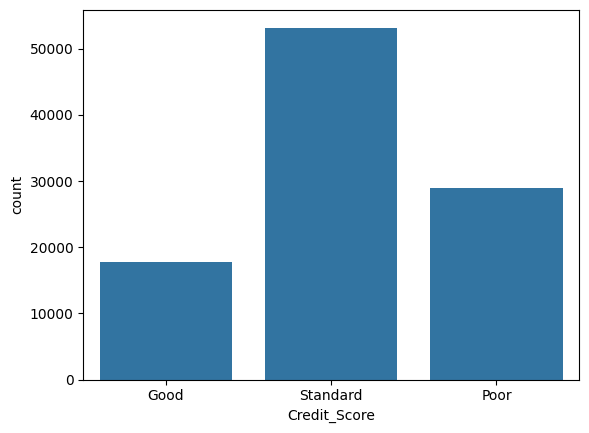

In [76]:
### Avaliando variavel target
sns.countplot(x = 'Credit_Score', data = df_f)


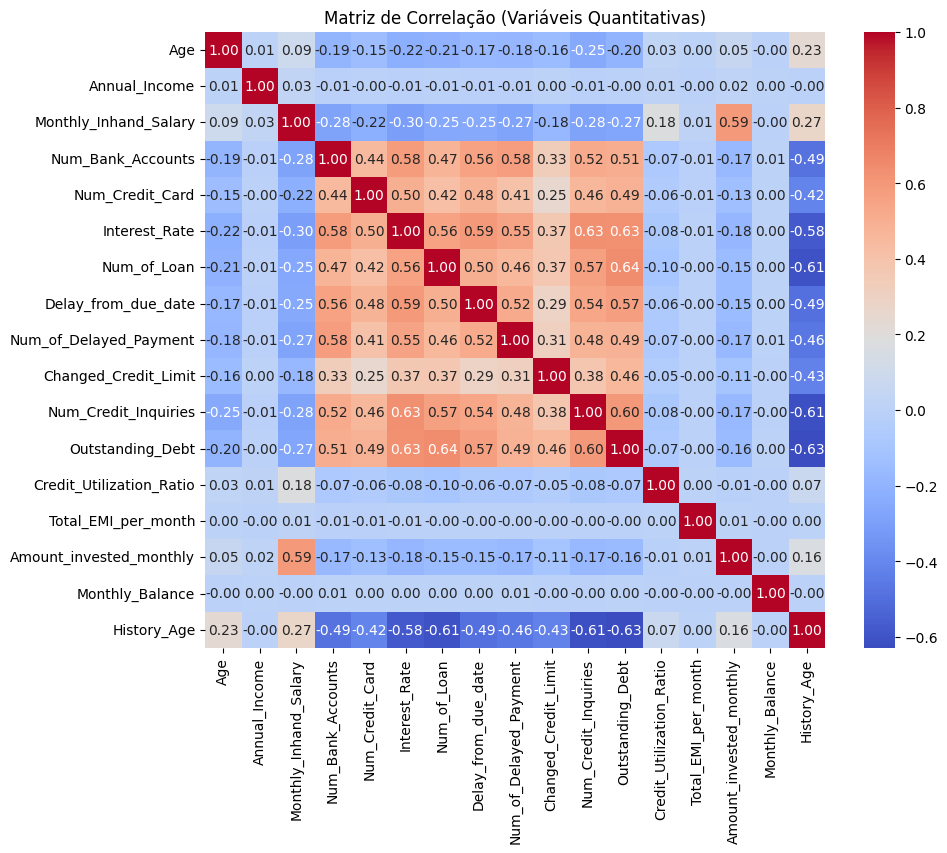

In [77]:
### gerando matriz de correlação com variaveis numericas
df_quantitativo = df_f.select_dtypes(include=['int64', 'float64'])

correlacao = df_quantitativo.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação (Variáveis Quantitativas)')
plt.show()

<Axes: xlabel='Annual_Income'>

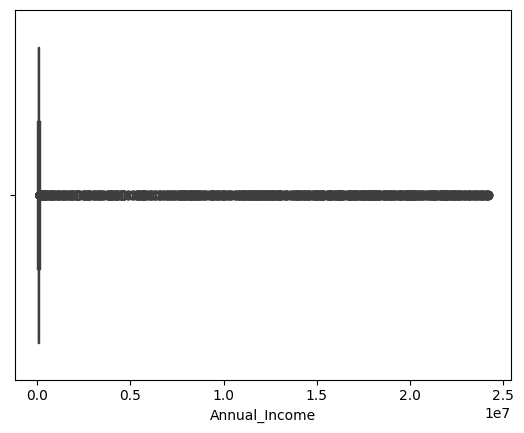

In [78]:
### avaliando anual income. Boxplot aponta necessidade de tratamento, pois temos muitos valores apontados como outliers
sns.boxplot(x = 'Annual_Income', data = df_f)

Intervalo interquartil (IQR): 53333.42


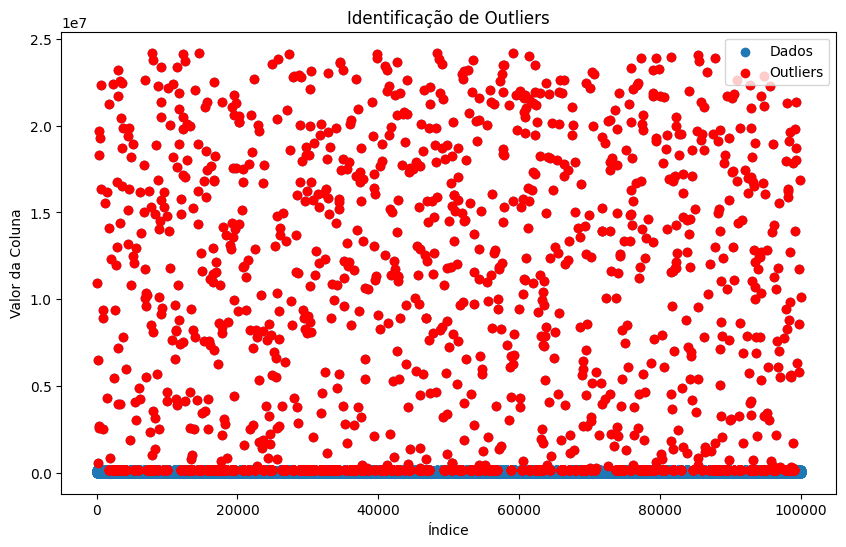

In [79]:
### verificando outliers
Q1 = np.percentile(df_f['Annual_Income'], 25)
Q3 = np.percentile(df_f['Annual_Income'], 75)

IQR = Q3 - Q1

print("Intervalo interquartil (IQR):", IQR)

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_f[(df_f['Annual_Income'] < limite_inferior) | (df_f['Annual_Income'] > limite_superior)]

plt.figure(figsize=(10, 6))
plt.scatter(df_f.index, df_f['Annual_Income'], label='Dados')
plt.scatter(outliers.index, outliers['Annual_Income'], color='r', label='Outliers')
plt.xlabel('Índice')
plt.ylabel('Valor da Coluna')
plt.title('Identificação de Outliers')
plt.legend()
plt.show()

In [80]:
### substituindo valores
outlier_income = df_f['Annual_Income'] > limite_superior

mode_Income = df_f.groupby('Customer_ID')['Annual_Income'].transform(lambda x : x.mode().iloc[0])
df_f['Annual_Income'] = np.where(outlier_income, mode_Income, df_f['Annual_Income'])

<Axes: xlabel='Annual_Income'>

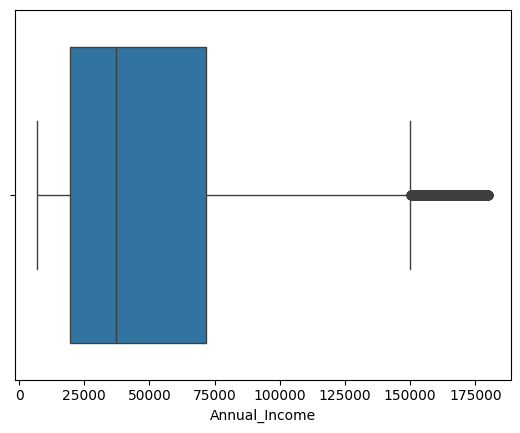

In [81]:
### avaliando anual income após tratamento, agora a distribuição é melhor
sns.boxplot(x = 'Annual_Income', data = df_f)

<Axes: xlabel='Monthly_Inhand_Salary'>

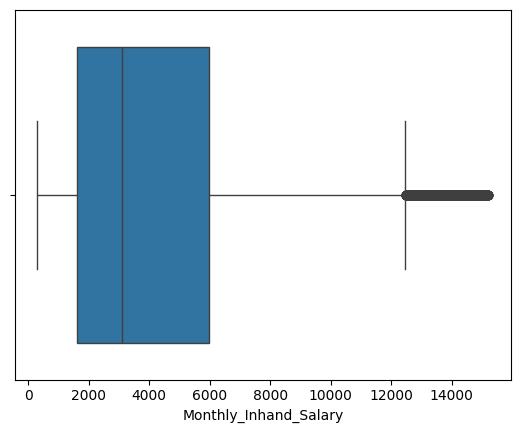

In [82]:
### avaliando salario mensal. Distribuição parece ok
sns.boxplot(x = 'Monthly_Inhand_Salary', data = df_f)


<Axes: xlabel='Total_EMI_per_month'>

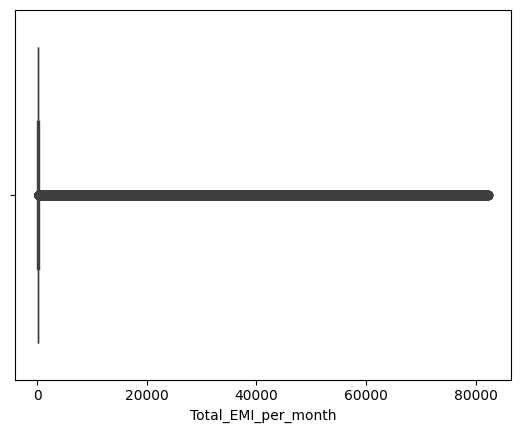

In [83]:
### avaliando Total_EMI_per_month. Comportamento similar a Annual_Income. Vamos tratar o dado
sns.boxplot(x = 'Total_EMI_per_month', data = df_f)

Intervalo interquartil (IQR): 130.91758861501165


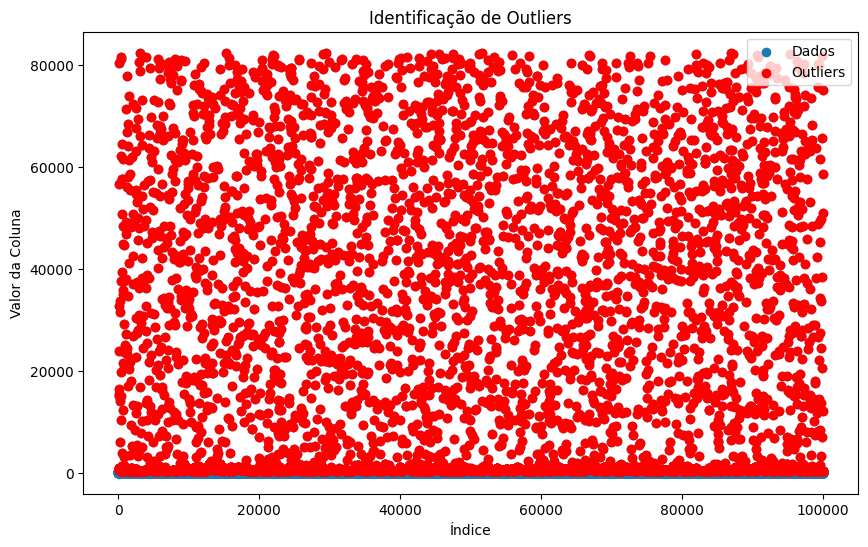

In [84]:
### verificando outliers
Q1 = np.percentile(df_f['Total_EMI_per_month'], 25)
Q3 = np.percentile(df_f['Total_EMI_per_month'], 75)

IQR = Q3 - Q1

print("Intervalo interquartil (IQR):", IQR)

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_f[(df_f['Total_EMI_per_month'] < limite_inferior) | (df_f['Total_EMI_per_month'] > limite_superior)]

plt.figure(figsize=(10, 6))
plt.scatter(df_f.index, df_f['Total_EMI_per_month'], label='Dados')
plt.scatter(outliers.index, outliers['Total_EMI_per_month'], color='r', label='Outliers')
plt.xlabel('Índice')
plt.ylabel('Valor da Coluna')
plt.title('Identificação de Outliers')
plt.legend()
plt.show()

In [85]:
### substituindo valores
outlier_Total_EMI_per_month = df_f['Total_EMI_per_month'] > limite_superior

mode_Total_EMI_per_month = df_f.groupby('Customer_ID')['Total_EMI_per_month'].transform(lambda x : x.mode().iloc[0])
df_f['Total_EMI_per_month'] = np.where(outlier_Total_EMI_per_month, mode_Total_EMI_per_month, df_f['Total_EMI_per_month'])

<Axes: xlabel='Total_EMI_per_month'>

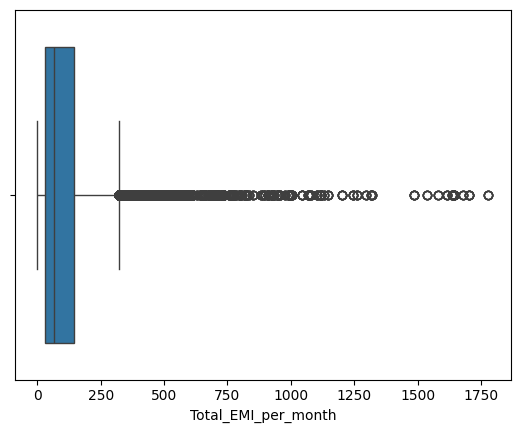

In [86]:
### avaliando Total_EMI_per_month pós tratamento. Ainda temos uma quantidade significativa de outliers, porém a distribuição melhorou
sns.boxplot(x = 'Total_EMI_per_month', data = df_f)

In [87]:
### avaliando Loan_Type
df_f['Type_of_Loan'].value_counts()

Type_of_Loan
Not Specified                                                                                                                         1408
Credit-Builder Loan                                                                                                                   1280
Personal Loan                                                                                                                         1272
Debt Consolidation Loan                                                                                                               1264
Student Loan                                                                                                                          1240
                                                                                                                                      ... 
Not Specified, Mortgage Loan, Auto Loan, and Payday Loan                                                                                 8
Payday Loan, M

In [88]:
### substituindo valores
df_f['Type_of_Loan'] = df_f['Type_of_Loan'].fillna('Not Specified')
df_f['Loan_Type'] = df_f['Type_of_Loan'].str.split(',', n=1).str[0]


In [89]:
### verificando nulos. Agora não temos mais nenhum valor nulo
df_f.isnull().sum()

Customer_ID                 0
Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
History_Age                 0
Loan_Type                   0
dtype: int64

In [90]:
### verificando tipos novamente. Tudo parece ok para criar o modelo
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Age                       100000 non-null  int64  
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  float64
 4   Monthly_Inhand_Salary     100000 non-null  float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  float64
 9   Type_of_Loan              100000 non-null  object 
 10  Delay_from_due_date       100000 non-null  float64
 11  Num_of_Delayed_Payment    100000 non-null  float64
 12  Changed_Credit_Limit      100000 non-null  float64
 13  Num_Credit_Inquiries      100000 non-null  fl

In [91]:
### drop do customer_id
df_f = df_f.drop(['Customer_ID', 'Type_of_Loan'], axis=1)

In [92]:
### realizando one-hot-encoding para variaveis categoricas
df_encoded = pd.get_dummies(df_f, columns=['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount',
                                           'Payment_Behaviour', 'Loan_Type'],
                            dtype=int, drop_first = True)

<Axes: >

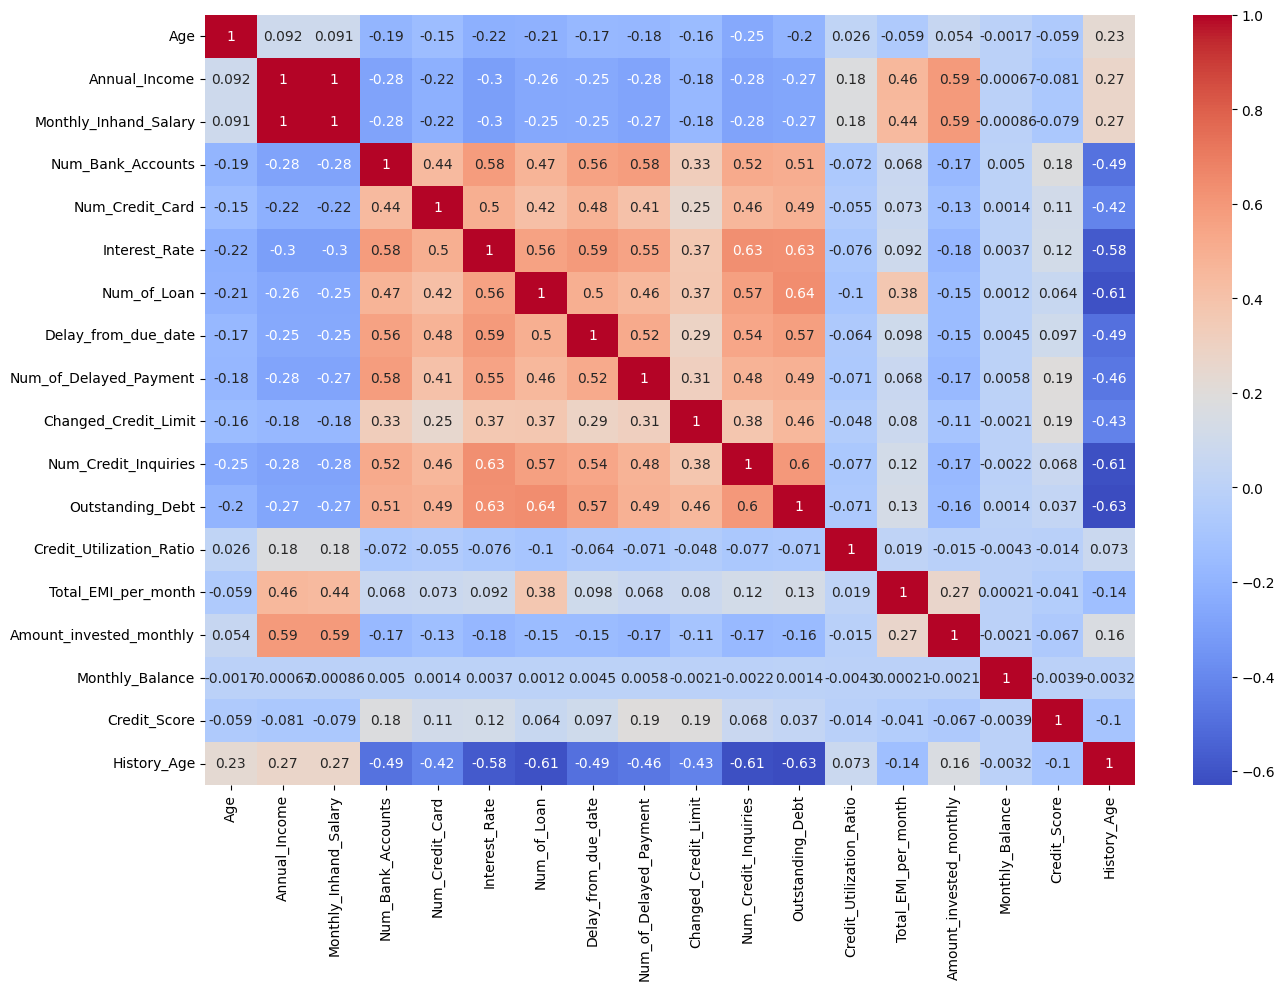

In [93]:
### fazer necoding do label para melhor output
label_encoder = LabelEncoder()
df_encoded['Credit_Score'] = label_encoder.fit_transform(df_encoded['Credit_Score'])

df_heatmap = df_f.drop(['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour','Loan_Type'], axis = 1)

df_heatmap['Credit_Score'] = df_encoded['Credit_Score']

plt.figure(figsize = (15,10))
sns.heatmap(df_heatmap.corr(), annot=True, cmap='coolwarm')

In [95]:
### drop de variaveis que não seram utilizadas
### 1) Monthly Balance: baixissima correlação com a variavl target (menor de todas)
### 2) Credit utilization score: segundo r mais baixo com a variavel target
### 3) Monthly Inhand Sallary: correlação de 1:1 com Annual Income, este que tem maior correlação com a variável target

df_encoded = df_encoded.drop(['Monthly_Balance','Credit_Utilization_Ratio','Monthly_Inhand_Salary'], axis = 1)

In [96]:
### inicio do treino do modelo
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 48 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Age                                                 100000 non-null  int64  
 1   Annual_Income                                       100000 non-null  float64
 2   Num_Bank_Accounts                                   100000 non-null  int64  
 3   Num_Credit_Card                                     100000 non-null  int64  
 4   Interest_Rate                                       100000 non-null  int64  
 5   Num_of_Loan                                         100000 non-null  float64
 6   Delay_from_due_date                                 100000 non-null  float64
 7   Num_of_Delayed_Payment                              100000 non-null  float64
 8   Changed_Credit_Limit                                100000 non-nu

In [97]:
### iniciando treino do modelo
X = df_encoded.drop('Credit_Score', axis=1)
y = df_encoded['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [98]:
### transformando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [99]:
### instanciando algoritmos
lr = LogisticRegression(max_iter=2000)
dtc = DecisionTreeClassifier()
svc = SVC()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
rfc = RandomForestClassifier()
mlpc = MLPClassifier()



In [100]:
### Criar ensembler para escolha do modelo
ensemble_model = VotingClassifier(estimators=[('dt', dtc), ('svc', svc), ('gb', gbc), ('ab', abc), ('knn', knn), ('mlp',mlpc)], voting='hard')


ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test,y_pred))
print(conf_matrix)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.61      0.78      0.69      3608
           1       0.76      0.73      0.75      5809
           2       0.81      0.75      0.78     10583

    accuracy                           0.75     20000
   macro avg       0.73      0.75      0.74     20000
weighted avg       0.76      0.75      0.75     20000

[[2801   30  777]
 [ 421 4261 1127]
 [1336 1317 7930]]


In [101]:
### validando a relevância de cada variavel para o modelo
rfc = RandomForestClassifier()
rfc.fit(X, y)

importances = rfc.feature_importances_

indices = np.argsort(importances)[::-1]

for i in range(len(importances)):
    print(f"{i + 1}. {X.columns[indices[i]]}: {importances[indices[i]]}")

1. Outstanding_Debt: 0.10220472360877365
2. History_Age: 0.08679856727146208
3. Interest_Rate: 0.07523891689743815
4. Delay_from_due_date: 0.06677728836671319
5. Amount_invested_monthly: 0.06392665983843523
6. Changed_Credit_Limit: 0.058929601241102775
7. Num_of_Delayed_Payment: 0.04493432876833116
8. Annual_Income: 0.04435383997657498
9. Num_Credit_Inquiries: 0.04421569549840627
10. Credit_Mix_Standard: 0.043420637897488464
11. Credit_Mix_Good: 0.04232653970736876
12. Num_Credit_Card: 0.041711238229303706
13. Age: 0.04079884372983366
14. Total_EMI_per_month: 0.04055151869824927
15. Num_Bank_Accounts: 0.03262387571328592
16. Num_of_Loan: 0.02551941760156932
17. Payment_of_Min_Amount_Yes: 0.014340557393194854
18. Payment_Behaviour_Low_spent_Small_value_payments: 0.00916449663071242
19. Payment_Behaviour_High_spent_Medium_value_payments: 0.008611969247260829
20. Payment_Behaviour_Low_spent_Medium_value_payments: 0.007689579487662684
21. Payment_Behaviour_High_spent_Small_value_payments: 

In [102]:
### selecionando as 17 variaveis mais relevantes
most_relevant = ['Outstanding_Debt','History_Age','Interest_Rate',
                 'Delay_from_due_date','Amount_invested_monthly','Changed_Credit_Limit',
                 'Num_Credit_Inquiries','Credit_Mix_Good','Num_of_Delayed_Payment','Annual_Income',
                 'Credit_Mix_Standard','Age','Total_EMI_per_month','Num_Credit_Card','Num_Bank_Accounts','Num_of_Loan','Payment_of_Min_Amount_Yes','Credit_Score']

df_selected = df_encoded[most_relevant]

df_selected.head()

,Outstanding_Debt,History_Age,Interest_Rate,Delay_from_due_date,Amount_invested_monthly,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix_Good,Num_of_Delayed_Payment,Annual_Income,Credit_Mix_Standard,Age,Total_EMI_per_month,Num_Credit_Card,Num_Bank_Accounts,Num_of_Loan,Payment_of_Min_Amount_Yes,Credit_Score
0,809.98,265.0,3,3.0,80.415295,11.27,4.0,1,7.0,19114.12,0,23,49.574949,4,3,4.0,0,0
1,809.98,266.0,3,4.0,118.280222,11.27,4.0,1,14.0,19114.12,0,23,49.574949,4,3,4.0,0,0
2,809.98,267.0,3,3.0,81.699521,11.27,4.0,1,7.0,19114.12,0,23,49.574949,4,3,4.0,0,0
3,809.98,268.0,3,5.0,199.458074,6.27,4.0,1,4.0,19114.12,0,23,49.574949,4,3,4.0,0,0
4,809.98,269.0,3,6.0,41.420153,11.27,4.0,1,14.0,19114.12,0,23,49.574949,4,3,4.0,0,0


In [103]:
### fazendo novamente split de dados
X = df_selected.drop('Credit_Score', axis=1)
y = df_selected['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [104]:
###determinando se existe um K melhor para o modelo
k_range = range(1, 50)
scores = []

for k in k_range:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

[0.75415, 0.7617, 0.7638, 0.76215, 0.75255, 0.74695, 0.7328, 0.71535, 0.70815, 0.6914, 0.6847, 0.67925, 0.67675, 0.66965, 0.6629, 0.6592, 0.66355, 0.6548, 0.65845, 0.6545, 0.65235, 0.65175, 0.64925, 0.6488, 0.64705, 0.6474, 0.64295, 0.64165, 0.64575, 0.6483, 0.6394, 0.64595, 0.6381, 0.6398, 0.63745, 0.63855, 0.63815, 0.6412, 0.636, 0.6397, 0.6359, 0.63615, 0.6382, 0.62865, 0.6346, 0.63695, 0.6319, 0.63615, 0.6312]


Text(0, 0.5, 'Testing Accuracy')

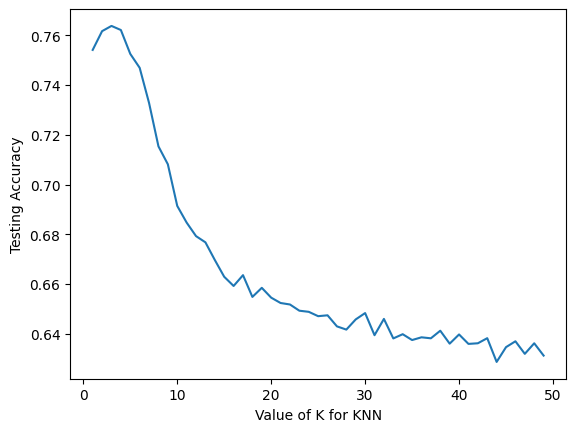

In [105]:
### exibindo os scores
print(scores)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [106]:
### Criar ensembler para escolha do modelo
knn = KNeighborsClassifier(n_neighbors=2)

ensemble_model = VotingClassifier(
    estimators=[('dt', dtc), ('svc', svc), ('gb', gbc), ('ab', abc), ('knn', knn), ('mlp',mlpc)], voting='hard')


ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test,y_pred))
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      3556
           1       0.78      0.72      0.75      5802
           2       0.79      0.77      0.78     10642

    accuracy                           0.75     20000
   macro avg       0.73      0.75      0.74     20000
weighted avg       0.76      0.75      0.75     20000

[[2660    9  887]
 [ 343 4158 1301]
 [1260 1178 8204]]


Sendo a classe 0 referente ao "Good", 1 referente ao "Bad" e 2 referente ao "Standard". Avaliando a matriz de confusão, é possivel notar que obtivemos uma acurácia de 76% para o modelo.

Porém quando avaliamos de forma mais profunda é possível notar que tivemos apenas 5% do público "Bad" classificado como "Good", sendo a clsse "Good" como a mais propícia para tomada de crédito, e a "Bad" a menos propícia, com isso o modelo torna-se mais eficiente do que é mostrado pela acurácia.
